In [1]:
import ugradio
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from datetime import datetime
from datetime import timedelta
import time
import numpy as np
import matplotlib.pyplot as plt

In [34]:
def take_data(obs_length, time_per_iter, dt):
    """
    - obs_length: observation time (minutes)
    - time_per_iter: how long to wait before moving the telescope again (seconds)
    - dt: how often to read voltage (seconds) (time resolution of data)
    
    RETURNS
    - final_data[0]: array of voltages
    - final_data[1]: array of times
    """
    
    volts = np.array([])
    freqs = np.array([])

    imf = ugradio.interf.Interferometer()
    hpm = ugradio.hp_multi.HP_Multimeter()
    
    start_time = ugradio.timing.julian_date() # define start time of observation
    delta_jd = obs_length/(24*60)
    end_time = start_time + delta_jd # define when to end observation
    
    jd = ugradio.timing.julian_date()
    
    # input the time and will return the alt and az of the sun
    def calc_sunpos(jd):
        ra, dec = ugradio.coord.sunpos(jd) # ra and dec sun coords
        lat, long, alt_nch = ugradio.nch.lat, ugradio.nch.lon, ugradio.nch.alt 
        alt, az = ugradio.coord.get_altaz(ra, dec, jd, lat, long, alt_nch)
        return alt, az
    
    # point to initial sun position
    alt, az = calc_sunpos(jd)
    print('Moving to initial Sun position...')
    imf.point(alt, az)
    
    i = 0
    hpm.start_recording(dt)
    while jd < end_time: 
        print(i, "iteration")
        # how often to move the telescope    
        time.sleep(time_per_iter)
        jd = ugradio.timing.julian_date()
        
        if i%10 == 0:
            final_data = hpm.get_recording_data()
            np.save("final_data.npy", final_data)
            
        alt, az = calc_sunpos(jd)
        
        #pointing
        try:
            imf.point(alt, az)
            print("Succesfully pointed, moved to new alt, az: {0:0.3f}, {1:0.3f}".format(alt, az))
            
        except:
            # check if object is in the northern sky
            if alt < ugradio.interf.ALT_MIN or alt > ugradio.interf.ALT_MAX: # if outside alt range
                alt -= 180
                print('Outside altitude range so flipping.')
                
            if az < ugradio.interf.AZ_MIN or az > ugradio.interf.AZ_MAX: # if outside az range
                az += 180
                print('Outside azimuth range so flipping.')
                
            try:
                imf.point(alt, az)
                print("Succesfully pointed, moved to new alt, az: {0:0.3f}, {1:0.3f}".format(alt, az))
                
            except:
                print("That shit failed, saving data and moving to stow position.")
                break
            
        i+=1

            
    final_data = hpm.get_recording_data()
    np.save("final_data.npy", final_data)
    
    hpm.end_recording() # end recording
    imf.stow() # stow telescope
    
    return final_data

In [42]:
# volts, times = take_data(2, 2, 0.1)

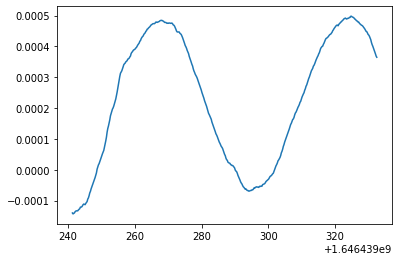

In [38]:
plt.plot(times, volts)

In [ ]:
#when the object is in the northern sky
#180 + az
#180 - alt